# Time Series Modeling

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values. Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series.

This notebook provides an example of how to train an ARIMA model in `statsmodels` libaray to generate forecasts of product sales in retail. We will train an ARIMA based model on the Superstore sales dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
sns.set(style="whitegrid")

## Loading Superstore Sales Data

In [2]:
data = pd.read_excel('../Data/Superstore.xls')
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Data Preprocessing

* filtering categories
* removing columns we do not need
* checking missing values
* aggregating sales by date and so on.

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [3]:
print('Suersore categories: ', data.Category.unique())
furniture = data.loc[data.Category == 'Furniture']
furniture.head()

Suersore categories:  ['Furniture' 'Office Supplies' 'Technology']


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


### Data Validation (Time Range, Missing Values)

In [4]:
print('Time range: {} to {}'.format(furniture['Order Date'].min(), furniture['Order Date'].min()))

Time range: 2014-01-06 00:00:00 to 2014-01-06 00:00:00


In [5]:
print('Verify missing valuse:')
furniture.columns[furniture.isnull().sum()>0]

Verify missing valuse:


Index([], dtype='object')

### Extract order year, month, day

The `map()` method only works on a pandas series where type of operation to be applied depends on argument passed as a function, dictionary or a list. This method is generally used to map values from two series having one column same.

However, the pandas also provides the function `.dt.strftime()` coverting datetime to string as `datetime.strftime`, which is more efficient than `map()`.

In [6]:
furniture['Order Year'] = furniture['Order Date'].dt.strftime('%Y')
furniture['Order Month'] = furniture['Order Date'].dt.strftime('%m')
furniture['Order Day'] = furniture['Order Date'].dt.strftime('%d')
furniture[['Order Year','Order Month','Order Day']].head()

# furniture['Order Year'] = furniture['Order Date'].map(lambda x: x.year)
# furniture['Order Month'] = furniture['Order Date'].map(lambda x: x.month)
# furniture['Order Day'] = furniture['Order Date'].map(lambda x: x.day)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

,Order Year,Order Month,Order Day
0,2016,11,08
1,2016,11,08
3,2015,10,11
5,2014,06,09
10,2014,06,09


### Data Aggregation

The `groupby` method can be used to aggregate our data by specific columns.

In [7]:
furniture_sales = furniture.groupby(['Order Year', 'Order Month']).Sales.agg(['sum'])
furniture_sales.head()

sum
Order Year Order Month           
2014       01            6242.525
           02            1839.658
           03           14573.956
           04            7944.837
           05            6912.787

The `resample()` method also allow us to do aggregation by month, but we need set timestamp as index first.

In [8]:
furniture_sales = furniture.set_index('Order Date').Sales.resample('M').sum()
furniture_sales.head()

Order Date
2014-01-31     6242.525
2014-02-28     1839.658
2014-03-31    14573.956
2014-04-30     7944.837
2014-05-31     6912.787
Freq: M, Name: Sales, dtype: float64

## Exploratory Data Analysis

The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year.

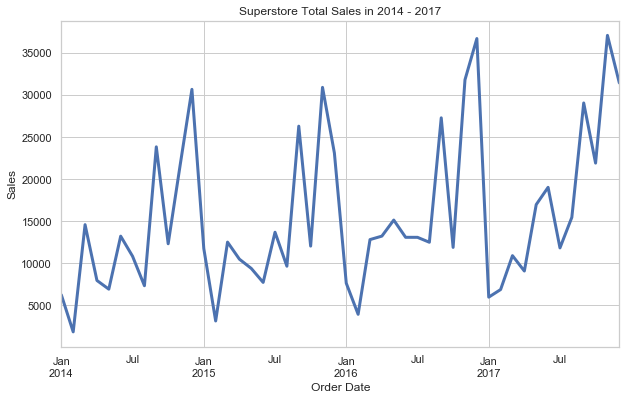

In [137]:
furniture_sales.plot(figsize=(10, 6), linewidth=3)
plt.ylabel('Sales')
plt.title('Superstore Total Sales in 2014 - 2017')
plt.show()

We can also visualize our data using a method called `time-series decomposition` that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

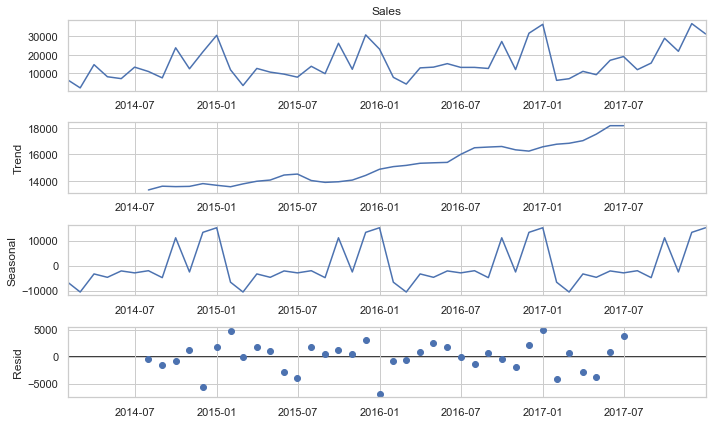

In [10]:
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(furniture_sales, model='additive')
fig = decomposition.plot()
plt.show()

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation $ARIMA(p, d, q)$. These three parameters account for seasonality, trend, and noise in data. The step is parameter selection for our furnitures's sales ARIMA time series model. Our goal here is to use `grid search` to find the optimal set of parameters that acheive the best performance for model.

SARIMA is used for non-stationary series, that is, where the data do not fluctuate around the same mean, variance and co-variance. This model can identify trend and seasonality, which makes it so important. The SARIMA consists of other forecasting models:
AR: Auto regressive model (can be a simple, multiple or non-linear regression)
MA: Moving averages model. The moving average models can use weighting factors, where the observations are weighted by a trim factor (for the oldest data in the series) and with a higher weight for the most recent observations.
The composition of AR and MA together carry the ARMA model, but this model is used only for stationary series (mean, variance constant over time).
If the series has a tendency, it will be necessary to use the ARIMA model.
ARIMA is used for non-stationary series. In this model, a differentiation step I (d) is used to eliminate non-stationarity.
The integrated element “I” for differentiation allows the method to support time series with trend. But still this model does not identify seasonality.
Finally, we arrive at the SARIMA model, which has a seasonal correlation and can identify the seasonality of the time series.

* p : The order of the auto-regressive (AR) model (i.e., the number of lag observations)
* d: The degree of differencing.
* q: The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data.

In [11]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
best_results = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture_sales,order=param,seasonal_order=param_seasonal,
                                            enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if best_results == []:
                best_results = [param, param_seasonal, results.aic]
            elif best_results[2] > results.aic:
                best_results = [param, param_seasonal, results.aic]
            else:
                continue
        except:
            continue

print('Best ARIMA parameters: ', best_results)

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jay48\AppData\Roaming\Python\Pytho

Best ARIMA parameters:  [(0, 1, 1), (0, 1, 1, 12), 418.3603349080472]


In [12]:
mod = sm.tsa.statespace.SARIMAX(furniture_sales,order=best_results[0],seasonal_order=best_results[1],
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9339      0.174     -5.372      0.000      -1.275      -0.593
ma.S.L12      -0.2149      0.346     -0.620      0.535      -0.894       0.464
sigma2      2.809e+07   8.48e-10   3.31e+16      0.000    2.81e+07    2.81e+07


<Figure size 432x288 with 0 Axes>

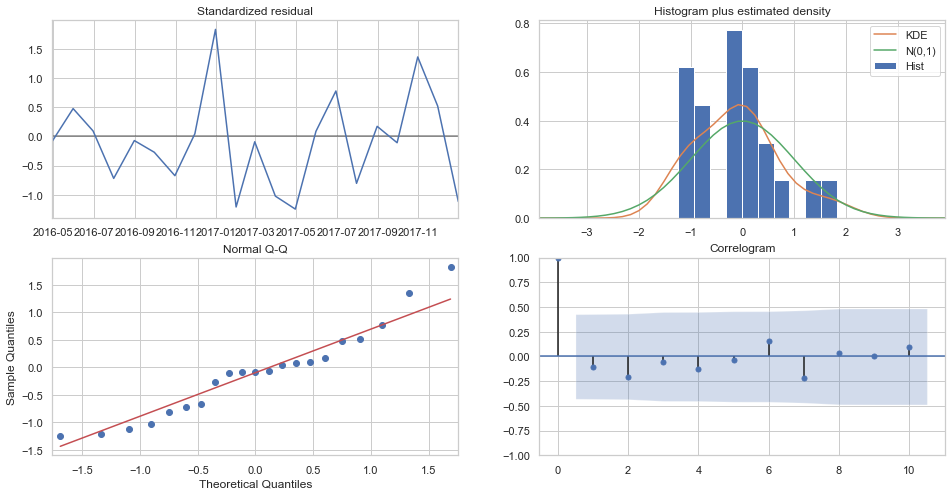

In [13]:
plt.figure(figsize=(6,4))
fig = results.plot_diagnostics(figsize=(16, 8))
plt.show()

We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset

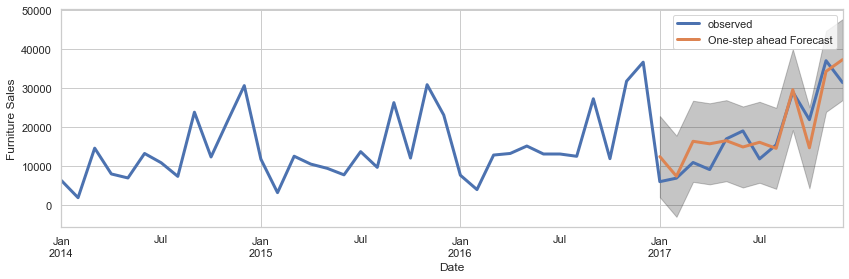

In [14]:
pred_start = furniture_sales.index[-12]

pred = results.get_prediction(start=pred_start, dynamic=False)
pred_ci = pred.conf_int()

ax = furniture_sales.plot(label='observed', figsize=(14, 4), linewidth=3)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', linewidth=3)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [15]:
y_forecasted = pred.predicted_mean
y_truth = furniture_sales[pred_start:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 20568872.39
The Root Mean Squared Error is 4535.29


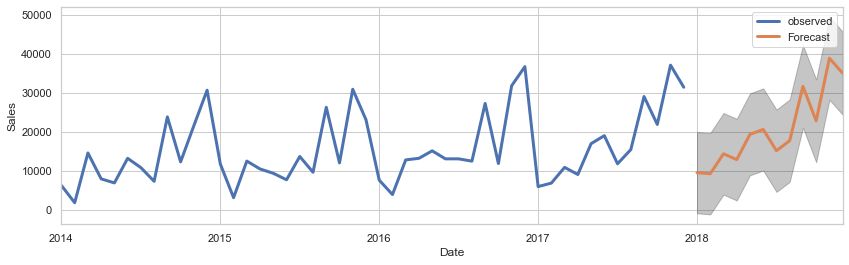

In [16]:
pred = results.get_forecast(steps=12)
pred_ci = pred.conf_int()

ax = furniture_sales.plot(label='observed', figsize=(14, 4), linewidth=3)
pred.predicted_mean.plot(ax=ax, label='Forecast', linewidth=3)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

## Time Series of Furniture vs. Office Supplies
According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [138]:
office = data[data.Category == 'Office Supplies']
office_sales = office.set_index('Order Date').Sales.resample('M').sum()
office_sales.head()

Order Date
2014-01-31     4851.080
2014-02-28     1071.724
2014-03-31     8605.879
2014-04-30    11155.074
2014-05-31     7135.624
Freq: M, Name: Sales, dtype: float64

In [140]:
assert(office_sales.shape == furniture_sales.shape)

store = pd.concat([furniture_sales, office_sales], axis=1)
store.columns = ['furniture', 'office']
store.head()

,furniture,office
Order Date,,
2014-01-31,6242.525,4851.080
2014-02-28,1839.658,1071.724
2014-03-31,14573.956,8605.879
2014-04-30,7944.837,11155.074
2014-05-31,6912.787,7135.624


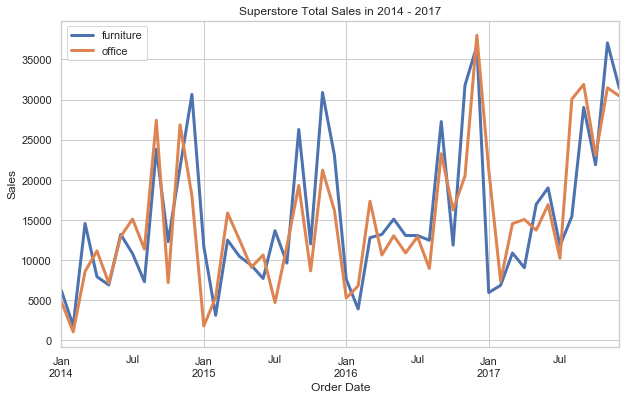

In [141]:
store.plot(figsize=(10, 6), linewidth=3)
plt.ylabel('Sales')
plt.title('Superstore Total Sales in 2014 - 2017')
plt.show()

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionally, office supplies passed furniture on average daily sales.